<a href="https://colab.research.google.com/github/MustafaBozkurt84/predictive-maintanance-LSTM/blob/master/LSTMTimeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from array import array
import pickle

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [31]:
def pickle_all(key,value):
         pickle_out = open(key, "wb")
         pickle.dump(value, pickle_out)
         pickle_out.close()

In [5]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [6]:
df = pd.read_excel("/content/drive/MyDrive/Datasets/predictive maintance /AnalizDataPM.xlsx",engine='openpyxl')
df["Time"]= [str(i).replace("2020-02-02","2/2/2020").replace("2020-01-02","2/1/2020") for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time']) 
df['Time']=[str(i).split(":")[0] for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S
df=df.groupby("Time").mean()
df.reset_index(inplace=True)
df.to_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")
df.head()

Time      vibx      vibz  ...      zacc     crest     zfreq
0 2020-01-17 00:00:00  1.208404  0.968665  ...  0.260534  3.817392  0.070044
1 2020-01-17 01:00:00  1.173835  1.045636  ...  0.262390  3.857893  0.069983
2 2020-01-17 02:00:00  1.161203  0.959516  ...  0.259026  3.811876  0.069978
3 2020-01-17 03:00:00  1.191830  0.957197  ...  0.260562  3.833699  0.070006
4 2020-01-17 04:00:00  1.027394  0.860651  ...  0.231498  4.164031  0.060902

[5 rows x 7 columns]

In [32]:
def lstm(df,col,date,time_step,layer_num):
    print(f"{col}"+50*"*")
    df1=df.reset_index()[col]
    from sklearn.preprocessing import MinMaxScaler
    scaler=MinMaxScaler(feature_range=(0,1))
    df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
    pickle_all(f"/content/drive/MyDrive/model_predictive_maintanence/{col}_scaler_lstm_univarate.pkl",scaler)
    training_size=len(df[df["Time"] < date][col].tolist())
    test_size=len(df1)-training_size
    train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
    # reshape into X=t,t+1,t+2,t+3 and Y=t+4

    X_train, y_train = create_dataset(train_data, time_step)
    X_test, ytest = create_dataset(test_data, time_step)
    training_size,test_size
    
    # reshape input to be [samples, time steps, features] which is required for LSTM
    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
    model=Sequential()
    model.add(LSTM(layer_num,return_sequences=True,input_shape=(time_step,1)))
    model.add(LSTM(layer_num,return_sequences=True))
    model.add(LSTM(layer_num))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    
    model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=24,verbose=0)
    model.save(f"/content/drive/MyDrive/model_predictive_maintanence/{col}_lstm_univariate_model.h5")
    ### Lets Do the prediction and check performance metrics
    train_predict=model.predict(X_train)
    test_predict=model.predict(X_test)
    ##Transformback to original form
    train_predict=scaler.inverse_transform(train_predict)
    test_predict=scaler.inverse_transform(test_predict)
    ### Calculate RMSE performance metrics
    import math
    from sklearn.metrics import mean_squared_error
    Train_RMSE=math.sqrt(mean_squared_error(y_train,train_predict))
    ### Test Data RMSE
    Test_RMSE=math.sqrt(mean_squared_error(ytest,test_predict))
    print(f"Train RMSE: {Train_RMSE} /// Test RMSE {Test_RMSE} /// Time Step {time_step} /// Number of layer {layer_num}")
    ### Plotting 
    # shift train predictions for plotting
    import matplotlib.pyplot as plt
    look_back=time_step
    trainPredictPlot = np.empty_like(df1)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(df1)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
    # plot baseline and predictions
    plt.title(col)
    plt.plot(scaler.inverse_transform(df1))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()
    return Train_RMSE,Test_RMSE,model

In [33]:
def lstm_tuning(df,col):
    my_dict={}
    i=1
    for time_step_ in [3,10,15,20,30,50,90]:
        for layer_num_ in [20,30,50,100]:
            print(f"Number Of Training {i}")
            my_dict[i]=[]
            Train_RMSE,Test_RMSE,model=lstm(df=df,  col=col, date="2020-01-25 00:00:00", time_step=time_step_, layer_num=layer_num_)
            i=i+1
    

# vibx column Model Tuning

Number Of Training 1
vibx**************************************************
Train RMSE: 0.6291655254161406 /// Test RMSE 0.8207138158025498 /// Time Step 3 /// Number of layer 20


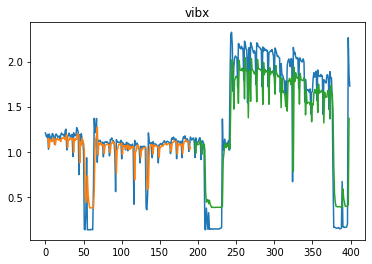

Number Of Training 2
vibx**************************************************
Train RMSE: 0.5996242146932966 /// Test RMSE 0.7506414881927469 /// Time Step 3 /// Number of layer 30


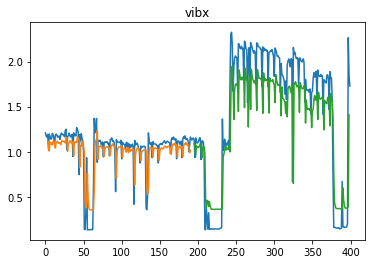

Number Of Training 3
vibx**************************************************
Train RMSE: 0.6731552681356218 /// Test RMSE 0.7674532134059939 /// Time Step 3 /// Number of layer 50


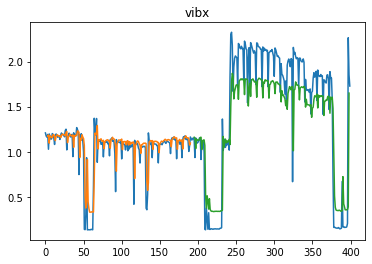

Number Of Training 4
vibx**************************************************
Train RMSE: 0.6218895722308273 /// Test RMSE 0.6242607572477391 /// Time Step 3 /// Number of layer 100


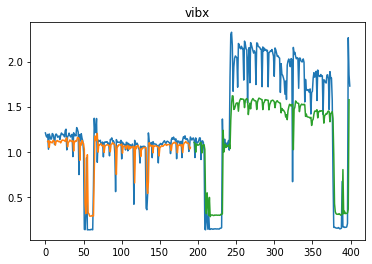

Number Of Training 5
vibx**************************************************
Train RMSE: 0.6092953177003002 /// Test RMSE 0.606408697835955 /// Time Step 10 /// Number of layer 20


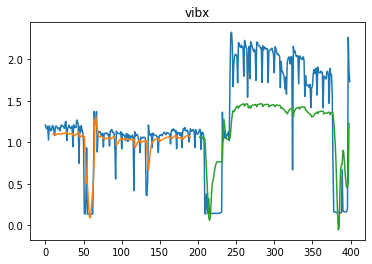

Number Of Training 6
vibx**************************************************
Train RMSE: 0.6167641048700825 /// Test RMSE 0.688373384271076 /// Time Step 10 /// Number of layer 30


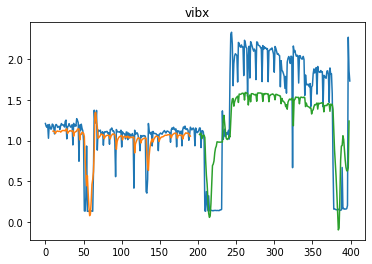

Number Of Training 7
vibx**************************************************
Train RMSE: 0.6427027148610363 /// Test RMSE 0.7128478828774624 /// Time Step 10 /// Number of layer 50


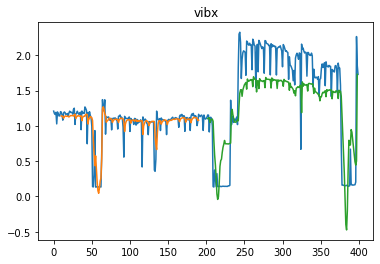

Number Of Training 8
vibx**************************************************
Train RMSE: 0.6598024373675947 /// Test RMSE 0.7562333594061172 /// Time Step 10 /// Number of layer 100


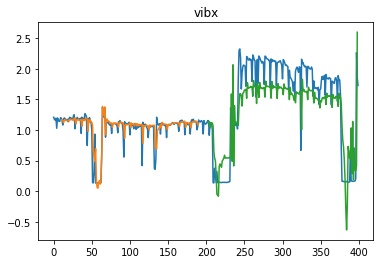

Number Of Training 9
vibx**************************************************
Train RMSE: 0.6115451203035529 /// Test RMSE 0.8018796013793348 /// Time Step 15 /// Number of layer 20


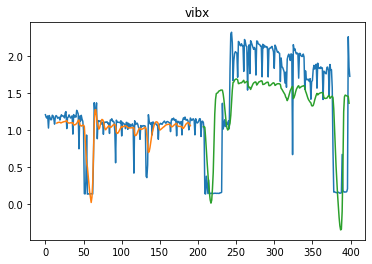

Number Of Training 10
vibx**************************************************
Train RMSE: 0.6800193167817835 /// Test RMSE 0.8134735663171455 /// Time Step 15 /// Number of layer 30


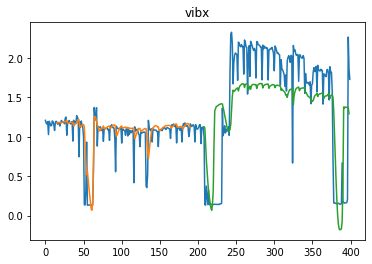

Number Of Training 11
vibx**************************************************
Train RMSE: 0.6521787572626092 /// Test RMSE 0.875663842320315 /// Time Step 15 /// Number of layer 50


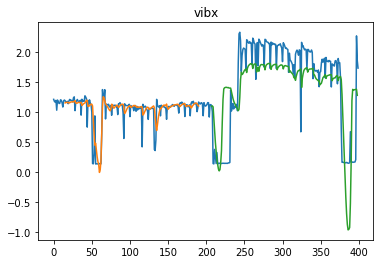

Number Of Training 12
vibx**************************************************
Train RMSE: 0.6098037162924421 /// Test RMSE 0.7878740592924767 /// Time Step 15 /// Number of layer 100


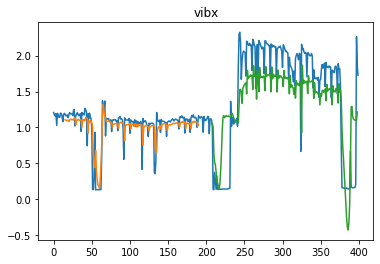

Number Of Training 13
vibx**************************************************
Train RMSE: 0.6455570861212632 /// Test RMSE 0.6778828604119734 /// Time Step 20 /// Number of layer 20


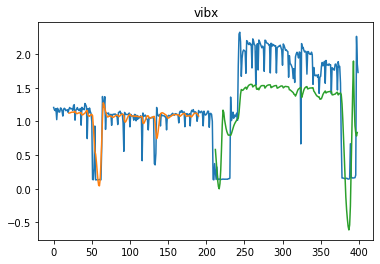

Number Of Training 14
vibx**************************************************
Train RMSE: 0.593066548049318 /// Test RMSE 0.8891906540497286 /// Time Step 20 /// Number of layer 30


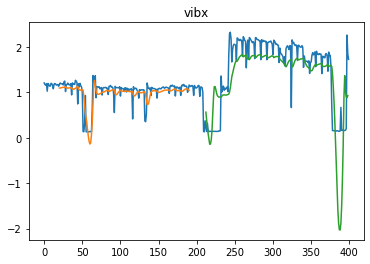

Number Of Training 15
vibx**************************************************
Train RMSE: 0.6475412816545091 /// Test RMSE 0.736951040518191 /// Time Step 20 /// Number of layer 50


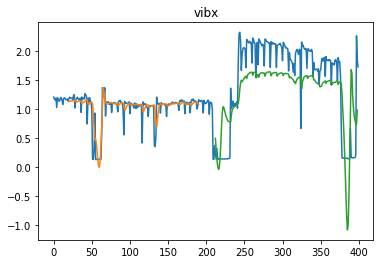

Number Of Training 16
vibx**************************************************
Train RMSE: 0.6143496008002951 /// Test RMSE 0.6293602186161898 /// Time Step 20 /// Number of layer 100


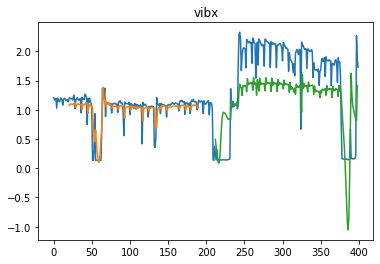

Number Of Training 17
vibx**************************************************
Train RMSE: 0.6213229391360786 /// Test RMSE 1.0833668642853358 /// Time Step 30 /// Number of layer 20


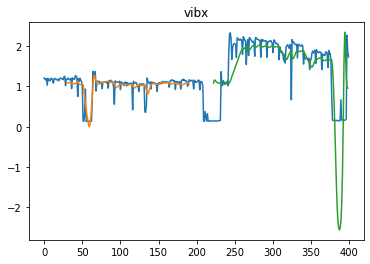

Number Of Training 18
vibx**************************************************
Train RMSE: 0.5892526053406661 /// Test RMSE 0.5855971123735491 /// Time Step 30 /// Number of layer 30


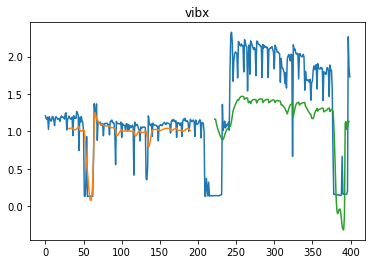

Number Of Training 19
vibx**************************************************
Train RMSE: 0.6125808093489342 /// Test RMSE 0.6620798665383453 /// Time Step 30 /// Number of layer 50


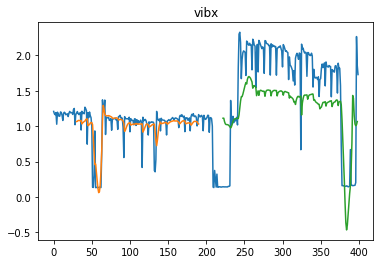

Number Of Training 20
vibx**************************************************
Train RMSE: 0.64342879539151 /// Test RMSE 0.8466474365364696 /// Time Step 30 /// Number of layer 100


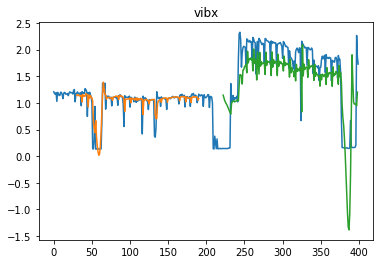

Number Of Training 21
vibx**************************************************
Train RMSE: 0.6128735172343801 /// Test RMSE 0.8034867166082117 /// Time Step 50 /// Number of layer 20


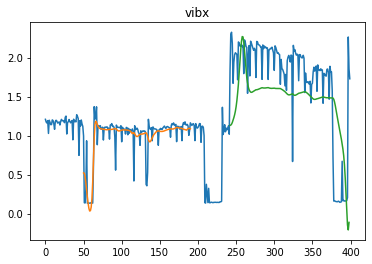

Number Of Training 22
vibx**************************************************
Train RMSE: 0.613633436697278 /// Test RMSE 0.8262761495399437 /// Time Step 50 /// Number of layer 30


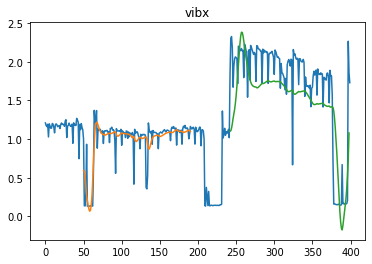

Number Of Training 23
vibx**************************************************
Train RMSE: 0.6115019996883113 /// Test RMSE 0.37593972841026957 /// Time Step 50 /// Number of layer 50


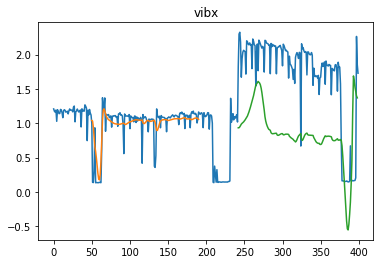

Number Of Training 24
vibx**************************************************
Train RMSE: 0.5814180849664167 /// Test RMSE 0.45372042617672564 /// Time Step 50 /// Number of layer 100


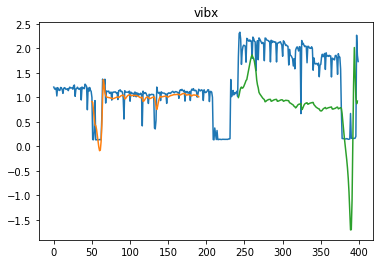

Number Of Training 25
vibx**************************************************
Train RMSE: 0.6588410304116985 /// Test RMSE 0.6238870932178837 /// Time Step 90 /// Number of layer 20


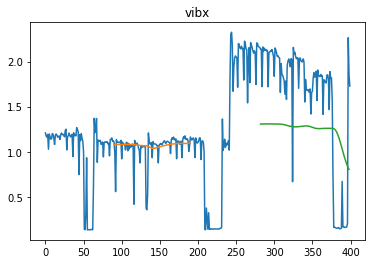

Number Of Training 26
vibx**************************************************
Train RMSE: 0.6090632349751368 /// Test RMSE 0.6101051225400008 /// Time Step 90 /// Number of layer 30


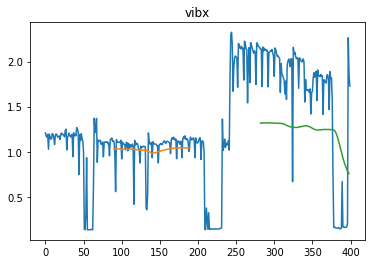

Number Of Training 27
vibx**************************************************
Train RMSE: 0.6244965125260957 /// Test RMSE 0.6095892213623343 /// Time Step 90 /// Number of layer 50


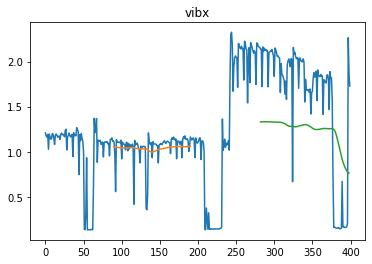

Number Of Training 28
vibx**************************************************
Train RMSE: 0.5954574914454858 /// Test RMSE 0.5394842892678647 /// Time Step 90 /// Number of layer 100


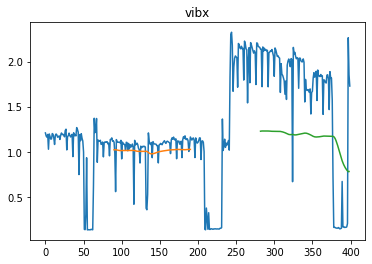

In [ ]:
lstm_tuning(df,'vibx')

# vibx column Best Model

vibx**************************************************
Train RMSE: 0.6257377739680663 /// Test RMSE 0.6038112368726282 /// Time Step 3 /// Number of layer 100


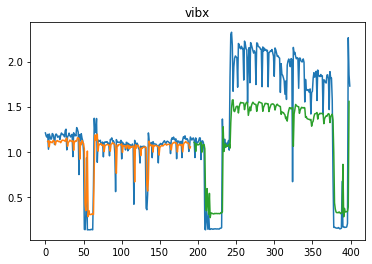

(0.6257377739680663,
 0.6038112368726282,
 <tensorflow.python.keras.engine.sequential.Sequential at 0x7f5b3665ebd0>)

In [34]:
lstm(df,"vibx","2020-01-25 00:00:00",time_step=3,layer_num=100)
      

# vibz column Model Tuning

Number Of Training 1
vibz**************************************************
Train RMSE: 0.6543596215817549 /// Test RMSE 0.6423606692697559 /// Time Step 3 /// Number of layer 20


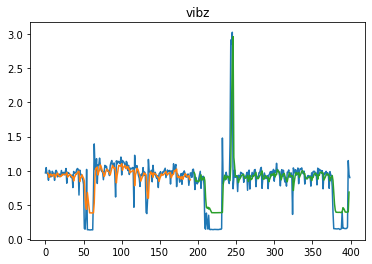

Number Of Training 2
vibz**************************************************
Train RMSE: 0.6337155260360822 /// Test RMSE 0.6146778725668034 /// Time Step 3 /// Number of layer 30


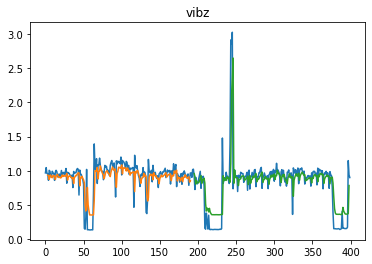

Number Of Training 3
vibz**************************************************
Train RMSE: 0.6750506005023913 /// Test RMSE 0.6411838946399271 /// Time Step 3 /// Number of layer 50


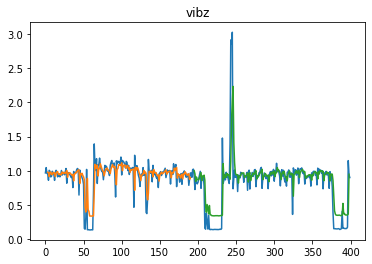

Number Of Training 4
vibz**************************************************
Train RMSE: 0.7014523955943441 /// Test RMSE 0.6568962978321343 /// Time Step 3 /// Number of layer 100


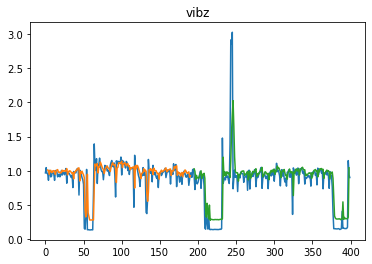

Number Of Training 5
vibz**************************************************
Train RMSE: 0.6606512142469614 /// Test RMSE 0.6851088935892495 /// Time Step 10 /// Number of layer 20


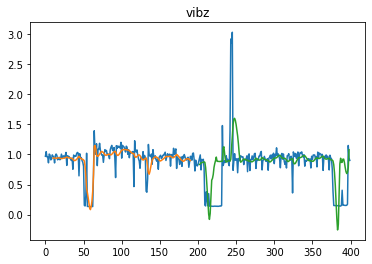

Number Of Training 6
vibz**************************************************
Train RMSE: 0.6916119262359112 /// Test RMSE 0.6706272753788176 /// Time Step 10 /// Number of layer 30


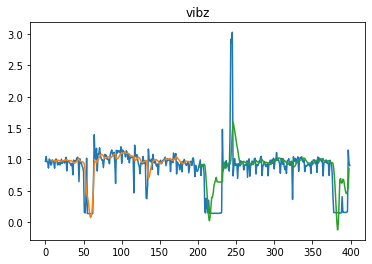

Number Of Training 7
vibz**************************************************
Train RMSE: 0.6596926260866462 /// Test RMSE 0.6638685182611157 /// Time Step 10 /// Number of layer 50


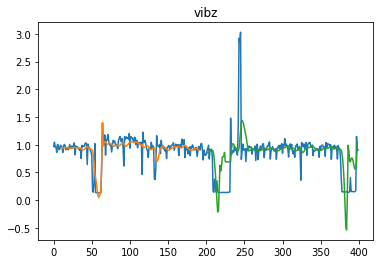

Number Of Training 8
vibz**************************************************
Train RMSE: 0.5917430332160888 /// Test RMSE 0.5844555265720984 /// Time Step 10 /// Number of layer 100


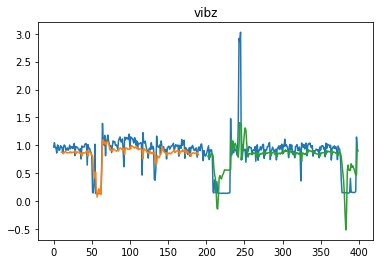

Number Of Training 9
vibz**************************************************
Train RMSE: 0.6655813068412398 /// Test RMSE 0.7438623070160615 /// Time Step 15 /// Number of layer 20


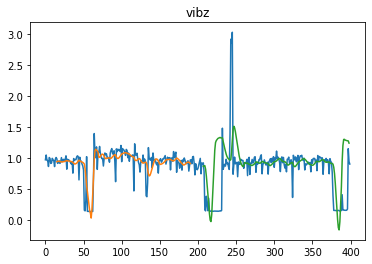

Number Of Training 10
vibz**************************************************
Train RMSE: 0.6550317363296453 /// Test RMSE 0.6941705849714767 /// Time Step 15 /// Number of layer 30


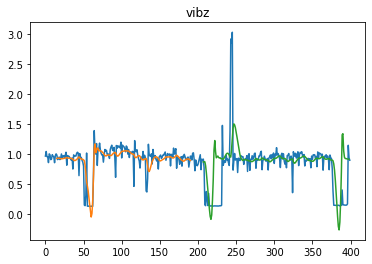

Number Of Training 11
vibz**************************************************
Train RMSE: 0.6412626990493291 /// Test RMSE 0.7163668676243093 /// Time Step 15 /// Number of layer 50


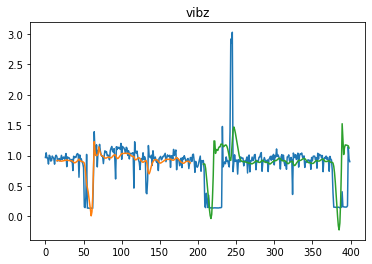

Number Of Training 12
vibz**************************************************
Train RMSE: 0.7019255363674198 /// Test RMSE 0.7336886856924965 /// Time Step 15 /// Number of layer 100


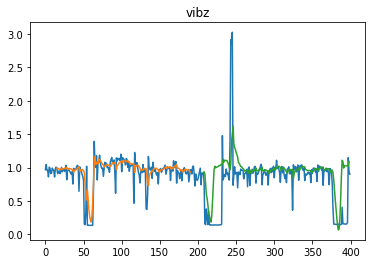

Number Of Training 13
vibz**************************************************
Train RMSE: 0.6508868592770841 /// Test RMSE 0.6954083088312176 /// Time Step 20 /// Number of layer 20


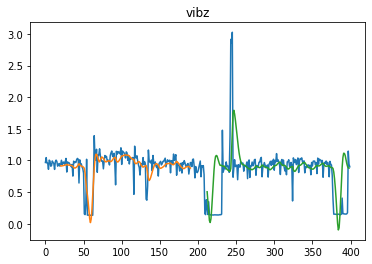

Number Of Training 14
vibz**************************************************
Train RMSE: 0.6757557950216023 /// Test RMSE 0.7287632309922105 /// Time Step 20 /// Number of layer 30


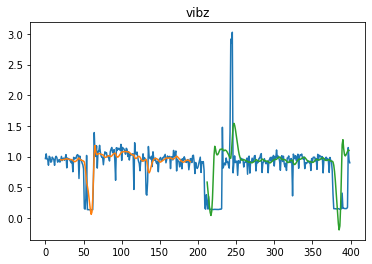

Number Of Training 15
vibz**************************************************
Train RMSE: 0.6572899780057376 /// Test RMSE 0.6917090556460566 /// Time Step 20 /// Number of layer 50


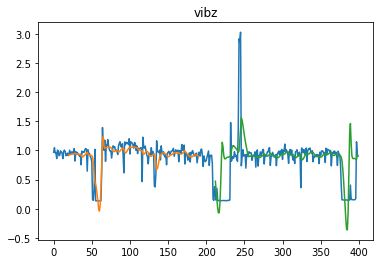

Number Of Training 16
vibz**************************************************
Train RMSE: 0.6701732043534799 /// Test RMSE 0.6628731943403101 /// Time Step 20 /// Number of layer 100


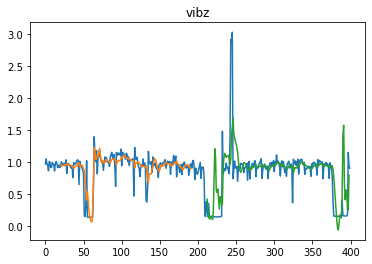

Number Of Training 17
vibz**************************************************
Train RMSE: 0.6512224045077173 /// Test RMSE 0.6840732281861122 /// Time Step 30 /// Number of layer 20


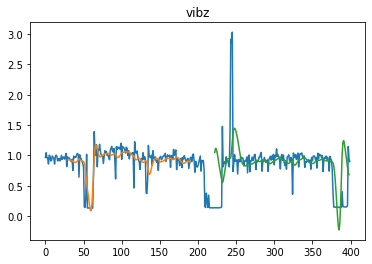

Number Of Training 18
vibz**************************************************
Train RMSE: 0.6680112190612333 /// Test RMSE 0.7148795656825406 /// Time Step 30 /// Number of layer 30


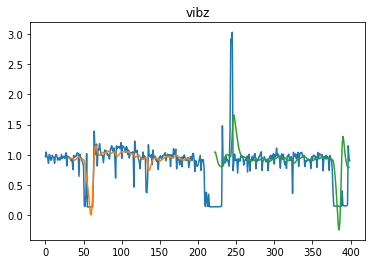

Number Of Training 19
vibz**************************************************
Train RMSE: 0.6452752266575965 /// Test RMSE 0.7084952976677003 /// Time Step 30 /// Number of layer 50


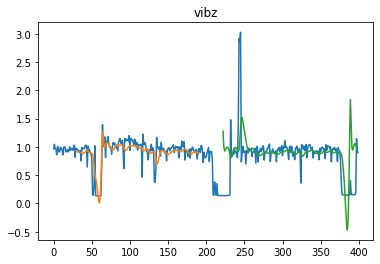

Number Of Training 20
vibz**************************************************
Train RMSE: 0.6792822506616046 /// Test RMSE 0.7132353749230366 /// Time Step 30 /// Number of layer 100


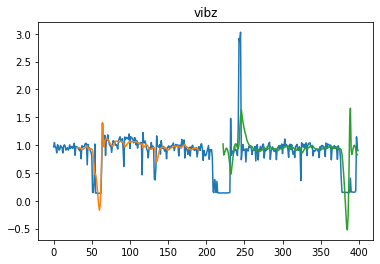

Number Of Training 21
vibz**************************************************
Train RMSE: 0.6808340559305478 /// Test RMSE 0.707196161205164 /// Time Step 50 /// Number of layer 20


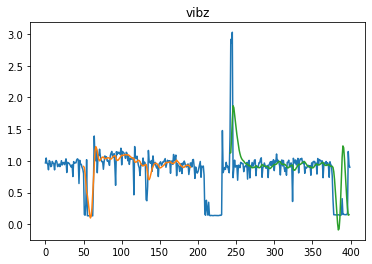

Number Of Training 22
vibz**************************************************
Train RMSE: 0.5988117412042302 /// Test RMSE 0.6398069093250629 /// Time Step 50 /// Number of layer 30


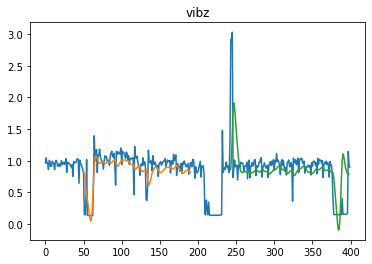

Number Of Training 23
vibz**************************************************
Train RMSE: 0.6718731128936464 /// Test RMSE 0.7035539230050777 /// Time Step 50 /// Number of layer 50


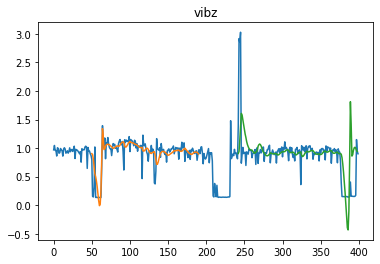

Number Of Training 24
vibz**************************************************
Train RMSE: 0.6714889143514949 /// Test RMSE 0.6942921648989735 /// Time Step 50 /// Number of layer 100


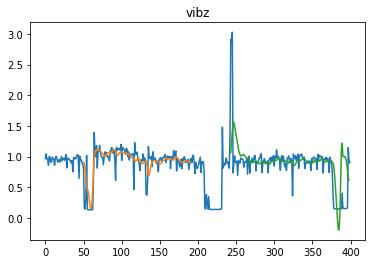

Number Of Training 25
vibz**************************************************
Train RMSE: 0.6330797936628477 /// Test RMSE 0.630137537128994 /// Time Step 90 /// Number of layer 20


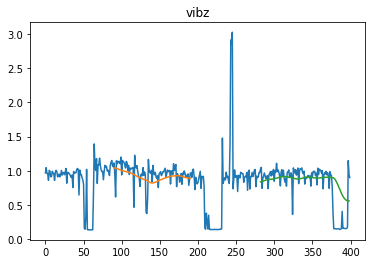

Number Of Training 26
vibz**************************************************
Train RMSE: 0.6604877748163239 /// Test RMSE 0.657306456537152 /// Time Step 90 /// Number of layer 30


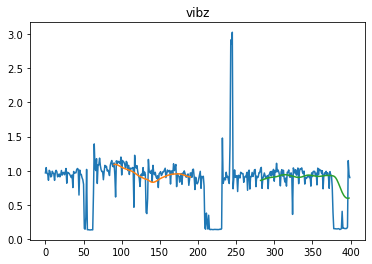

Number Of Training 27
vibz**************************************************
Train RMSE: 0.6531792995392955 /// Test RMSE 0.6526004109020658 /// Time Step 90 /// Number of layer 50


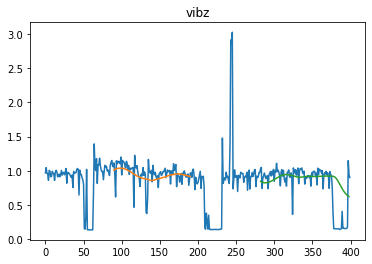

Number Of Training 28
vibz**************************************************
Train RMSE: 0.6852520305751835 /// Test RMSE 0.6901793132276972 /// Time Step 90 /// Number of layer 100


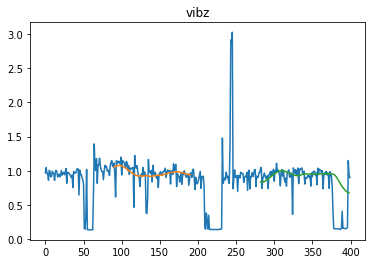

In [ ]:
lstm_tuning(df,'vibz')

# vibz column Best model

vibz**************************************************
Train RMSE: 0.6769360812986123 /// Test RMSE 0.638976481925553 /// Time Step 3 /// Number of layer 100


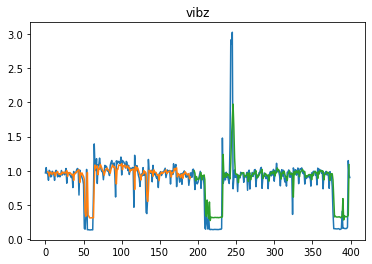

(0.6769360812986123,
 0.638976481925553,
 <tensorflow.python.keras.engine.sequential.Sequential at 0x7f5b39126ad0>)

In [35]:
lstm(df,"vibz","2020-01-25 00:00:00",time_step=3,layer_num=100)


# temp column Model Tuning

Number Of Training 1
temp**************************************************
Train RMSE: 26.601529237784 /// Test RMSE 25.9487528556087 /// Time Step 3 /// Number of layer 20


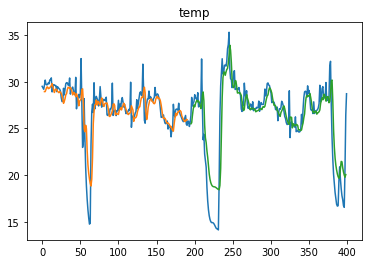

Number Of Training 2
temp**************************************************
Train RMSE: 26.50793001292226 /// Test RMSE 25.83017385515801 /// Time Step 3 /// Number of layer 30


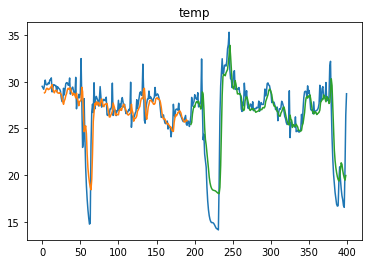

Number Of Training 3
temp**************************************************
Train RMSE: 26.843561694389752 /// Test RMSE 26.07719761399689 /// Time Step 3 /// Number of layer 50


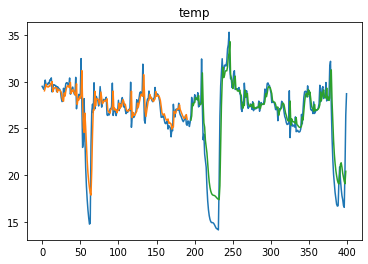

Number Of Training 4
temp**************************************************
Train RMSE: 26.597974149284163 /// Test RMSE 25.798918880803793 /// Time Step 3 /// Number of layer 100


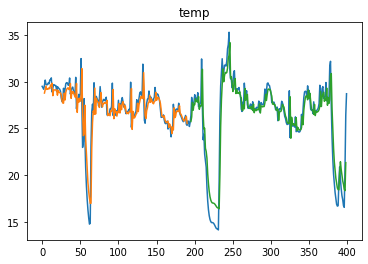

Number Of Training 5
temp**************************************************
Train RMSE: 27.258820451207168 /// Test RMSE 27.014221465586427 /// Time Step 10 /// Number of layer 20


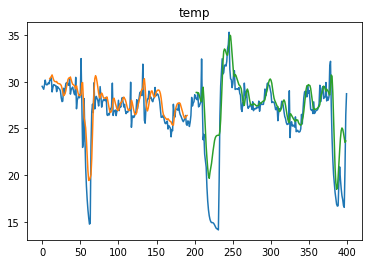

Number Of Training 6
temp**************************************************
Train RMSE: 26.204588091983343 /// Test RMSE 25.891226189785137 /// Time Step 10 /// Number of layer 30


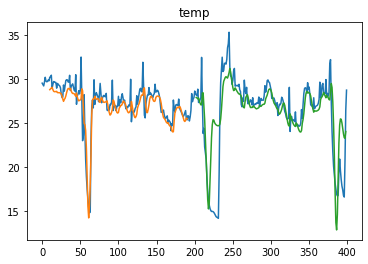

Number Of Training 7
temp**************************************************
Train RMSE: 26.917599666108792 /// Test RMSE 26.732328658895774 /// Time Step 10 /// Number of layer 50


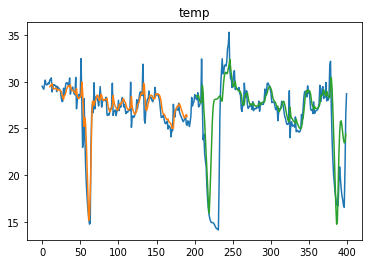

Number Of Training 8
temp**************************************************
Train RMSE: 26.361768468787627 /// Test RMSE 25.925712590055802 /// Time Step 10 /// Number of layer 100


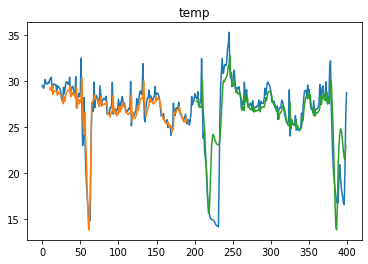

Number Of Training 9
temp**************************************************
Train RMSE: 26.349190523901214 /// Test RMSE 26.17400396621513 /// Time Step 15 /// Number of layer 20


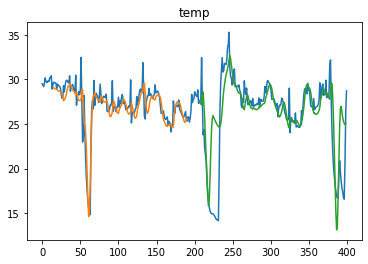

Number Of Training 10
temp**************************************************
Train RMSE: 27.35496470686193 /// Test RMSE 27.05484904567867 /// Time Step 15 /// Number of layer 30


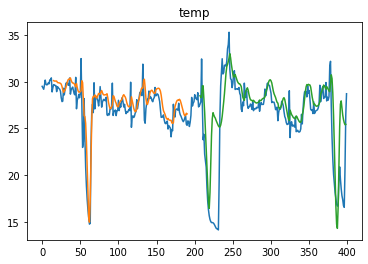

Number Of Training 11
temp**************************************************
Train RMSE: 26.015766872851405 /// Test RMSE 25.6772949638868 /// Time Step 15 /// Number of layer 50


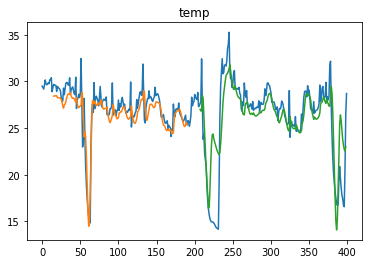

Number Of Training 12
temp**************************************************
Train RMSE: 25.971814884565376 /// Test RMSE 25.654679593080804 /// Time Step 15 /// Number of layer 100


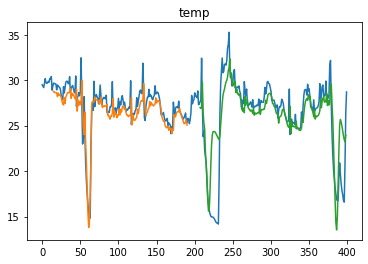

Number Of Training 13
temp**************************************************
Train RMSE: 26.61823364536377 /// Test RMSE 26.472342634886978 /// Time Step 20 /// Number of layer 20


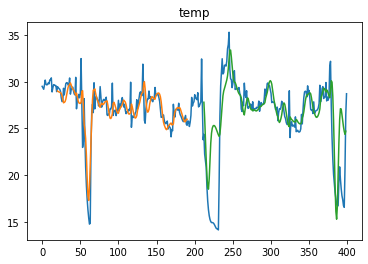

Number Of Training 14
temp**************************************************
Train RMSE: 27.0550197097307 /// Test RMSE 26.417819734868992 /// Time Step 20 /// Number of layer 30


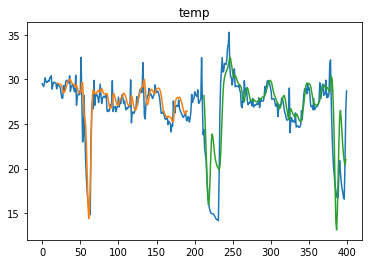

Number Of Training 15
temp**************************************************
Train RMSE: 27.143712822876 /// Test RMSE 26.559762161808198 /// Time Step 20 /// Number of layer 50


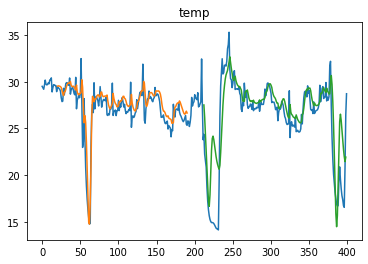

Number Of Training 16
temp**************************************************
Train RMSE: 25.98598608117399 /// Test RMSE 25.324197639693704 /// Time Step 20 /// Number of layer 100


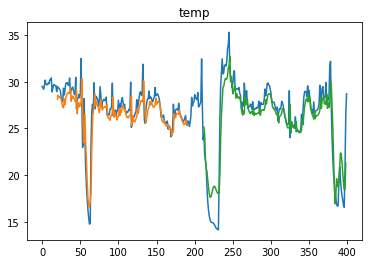

Number Of Training 17
temp**************************************************
Train RMSE: 26.230405471801177 /// Test RMSE 26.108882162397784 /// Time Step 30 /// Number of layer 20


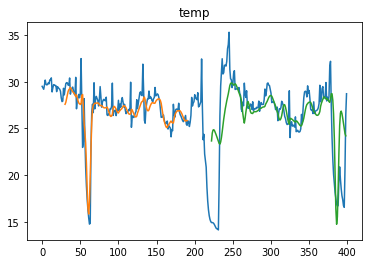

Number Of Training 18
temp**************************************************
Train RMSE: 26.726572768828188 /// Test RMSE 26.55573425565688 /// Time Step 30 /// Number of layer 30


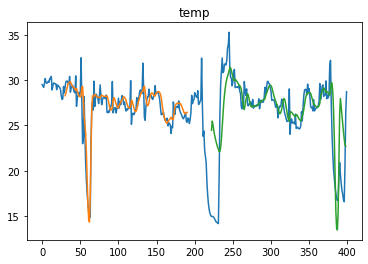

Number Of Training 19
temp**************************************************
Train RMSE: 26.270417926237222 /// Test RMSE 26.06948749815256 /// Time Step 30 /// Number of layer 50


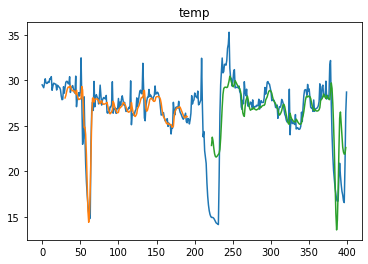

Number Of Training 20
temp**************************************************
Train RMSE: 26.275000240374776 /// Test RMSE 26.048302624672043 /// Time Step 30 /// Number of layer 100


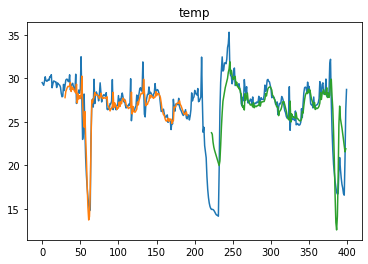

Number Of Training 21
temp**************************************************
Train RMSE: 26.16324908769596 /// Test RMSE 25.946567682532848 /// Time Step 50 /// Number of layer 20


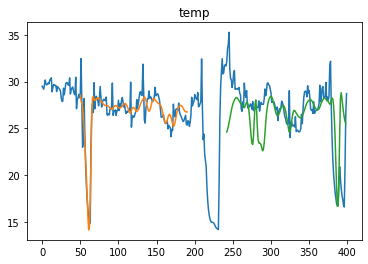

Number Of Training 22
temp**************************************************
Train RMSE: 26.30673918955844 /// Test RMSE 26.675006079430077 /// Time Step 50 /// Number of layer 30


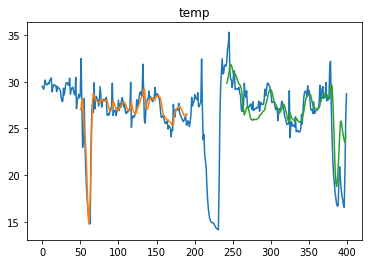

Number Of Training 23
temp**************************************************
Train RMSE: 26.406661360658298 /// Test RMSE 26.648130366903104 /// Time Step 50 /// Number of layer 50


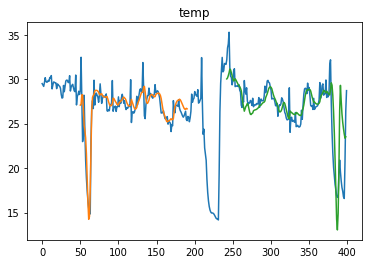

Number Of Training 24
temp**************************************************
Train RMSE: 25.983937404576725 /// Test RMSE 26.186151447774744 /// Time Step 50 /// Number of layer 100


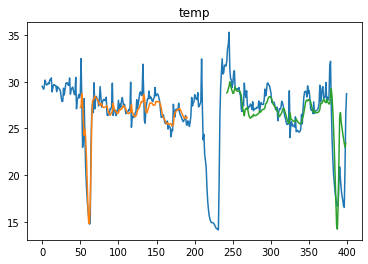

Number Of Training 25
temp**************************************************
Train RMSE: 26.136435446843198 /// Test RMSE 25.819805130284035 /// Time Step 90 /// Number of layer 20


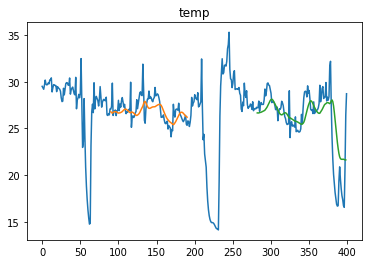

Number Of Training 26
temp**************************************************
Train RMSE: 26.33734704025139 /// Test RMSE 25.9757940129816 /// Time Step 90 /// Number of layer 30


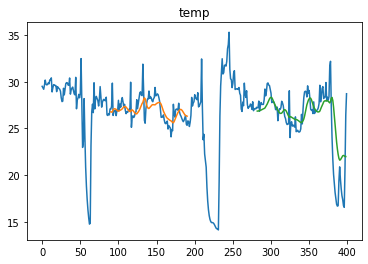

Number Of Training 27
temp**************************************************
Train RMSE: 26.71269249313414 /// Test RMSE 26.385962795375 /// Time Step 90 /// Number of layer 50


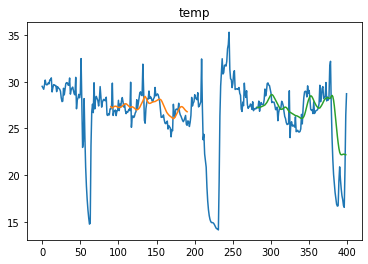

Number Of Training 28
temp**************************************************
Train RMSE: 26.879963440885607 /// Test RMSE 26.515246035234174 /// Time Step 90 /// Number of layer 100


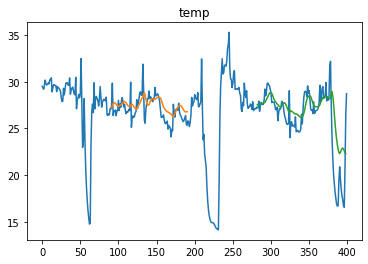

In [ ]:
lstm_tuning(df,df.columns[3])

# temp column Best Model

temp**************************************************
Train RMSE: 26.736707851905347 /// Test RMSE 25.935041910380406 /// Time Step 3 /// Number of layer 100


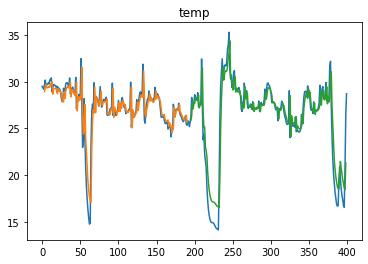

(26.736707851905347,
 25.935041910380406,
 <tensorflow.python.keras.engine.sequential.Sequential at 0x7f5b31697e10>)

In [36]:
lstm(df,"temp","2020-01-25 00:00:00",time_step=3,layer_num=100)

# zacc column model Tuning

Number Of Training 1
zacc**************************************************
Train RMSE: 0.08144107522178082 /// Test RMSE 0.16757294747944942 /// Time Step 3 /// Number of layer 20


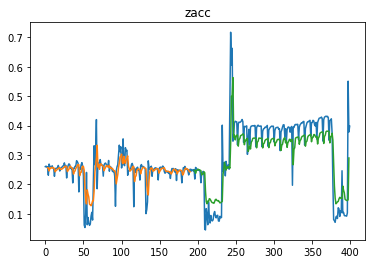

Number Of Training 2
zacc**************************************************
Train RMSE: 0.08555362446158808 /// Test RMSE 0.17869663641440323 /// Time Step 3 /// Number of layer 30


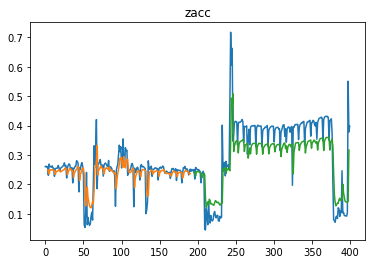

Number Of Training 3
zacc**************************************************
Train RMSE: 0.07994357336203516 /// Test RMSE 0.17295123865162995 /// Time Step 3 /// Number of layer 50


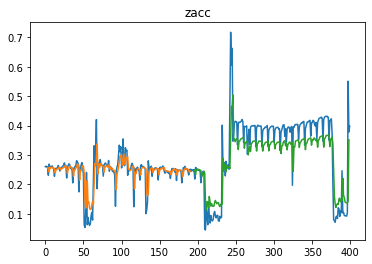

Number Of Training 4
zacc**************************************************
Train RMSE: 0.0847224892398144 /// Test RMSE 0.1855075366093076 /// Time Step 3 /// Number of layer 100


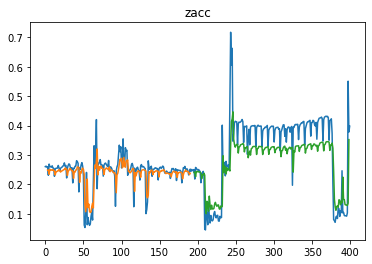

Number Of Training 5
zacc**************************************************
Train RMSE: 0.07770088807828825 /// Test RMSE 0.17312850601602436 /// Time Step 10 /// Number of layer 20


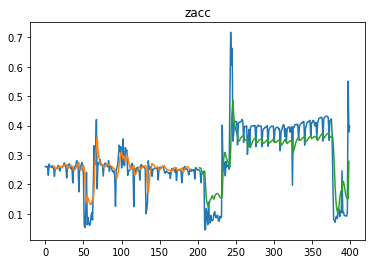

Number Of Training 6
zacc**************************************************
Train RMSE: 0.07700593808549933 /// Test RMSE 0.17682215334227452 /// Time Step 10 /// Number of layer 30


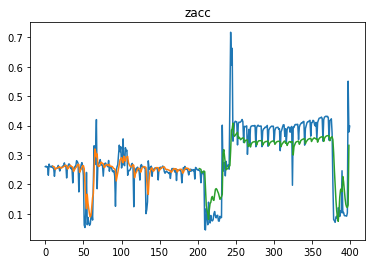

Number Of Training 7
zacc**************************************************
Train RMSE: 0.07768027450895912 /// Test RMSE 0.19810596181992554 /// Time Step 10 /// Number of layer 50


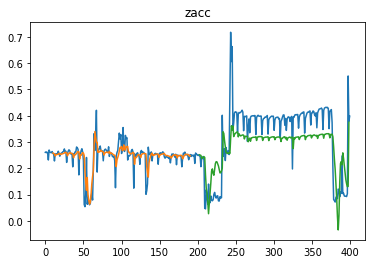

Number Of Training 8
zacc**************************************************
Train RMSE: 0.08110177561753137 /// Test RMSE 0.21379232705313964 /// Time Step 10 /// Number of layer 100


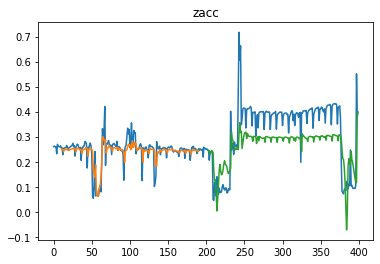

Number Of Training 9
zacc**************************************************
Train RMSE: 0.08442141524576173 /// Test RMSE 0.22308198382286482 /// Time Step 15 /// Number of layer 20


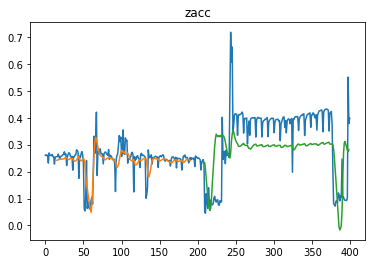

Number Of Training 10
zacc**************************************************
Train RMSE: 0.09015364248898972 /// Test RMSE 0.24418590685457622 /// Time Step 15 /// Number of layer 30


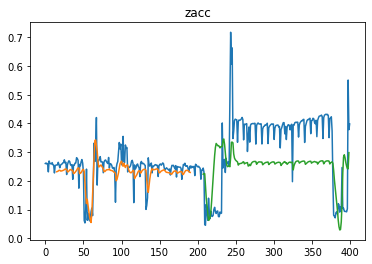

Number Of Training 11
zacc**************************************************
Train RMSE: 0.08702102452498452 /// Test RMSE 0.21151665819998064 /// Time Step 15 /// Number of layer 50


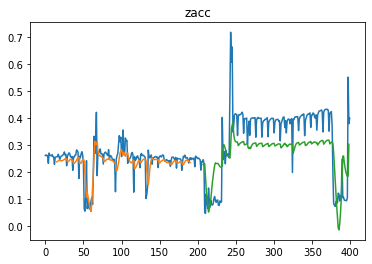

Number Of Training 12
zacc**************************************************
Train RMSE: 0.07950180478470793 /// Test RMSE 0.21148454062872662 /// Time Step 15 /// Number of layer 100


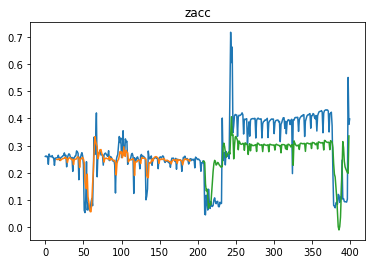

Number Of Training 13
zacc**************************************************
Train RMSE: 0.07994927631050949 /// Test RMSE 0.187043196481235 /// Time Step 20 /// Number of layer 20


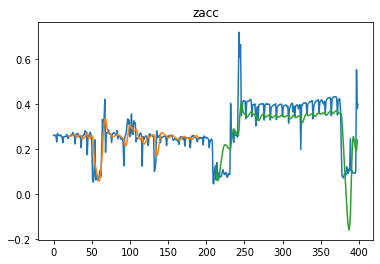

Number Of Training 14
zacc**************************************************
Train RMSE: 0.08124514757547678 /// Test RMSE 0.20279404282215868 /// Time Step 20 /// Number of layer 30


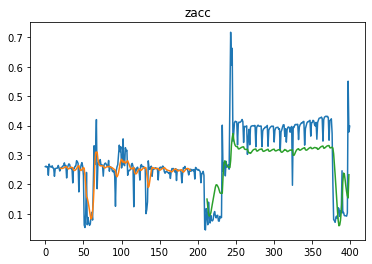

Number Of Training 15
zacc**************************************************
Train RMSE: 0.08211621309678455 /// Test RMSE 0.22239683864204146 /// Time Step 20 /// Number of layer 50


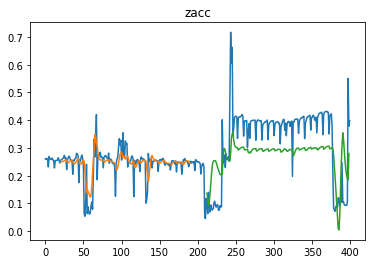

Number Of Training 16
zacc**************************************************
Train RMSE: 0.0730568534188602 /// Test RMSE 0.2010780483410055 /// Time Step 20 /// Number of layer 100


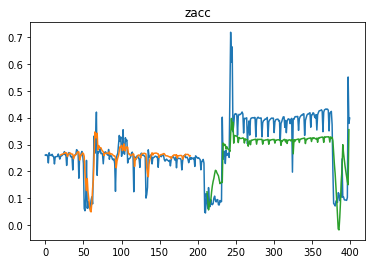

Number Of Training 17
zacc**************************************************
Train RMSE: 0.08266425537545928 /// Test RMSE 0.22210510111393986 /// Time Step 30 /// Number of layer 20


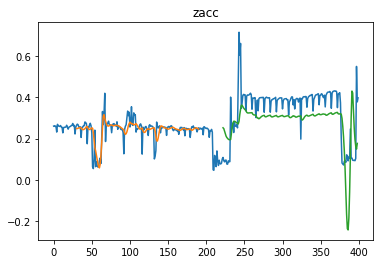

Number Of Training 18
zacc**************************************************
Train RMSE: 0.08276228580734553 /// Test RMSE 0.229756446218246 /// Time Step 30 /// Number of layer 30


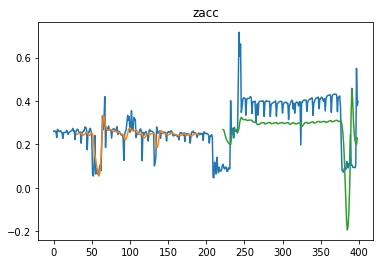

Number Of Training 19
zacc**************************************************
Train RMSE: 0.07685208075030824 /// Test RMSE 0.21306767541007102 /// Time Step 30 /// Number of layer 50


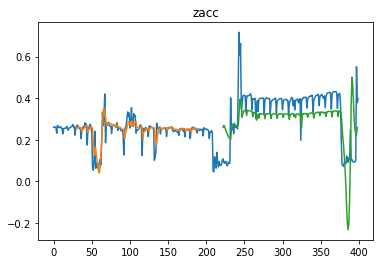

Number Of Training 20
zacc**************************************************
Train RMSE: 0.08405737015480043 /// Test RMSE 0.22427207144332476 /// Time Step 30 /// Number of layer 100


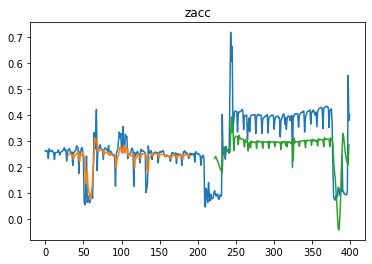

Number Of Training 21
zacc**************************************************
Train RMSE: 0.08278691405219821 /// Test RMSE 0.21843007497627276 /// Time Step 50 /// Number of layer 20


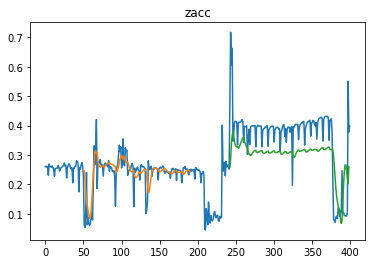

Number Of Training 22
zacc**************************************************
Train RMSE: 0.08271224577007665 /// Test RMSE 0.2364858534814173 /// Time Step 50 /// Number of layer 30


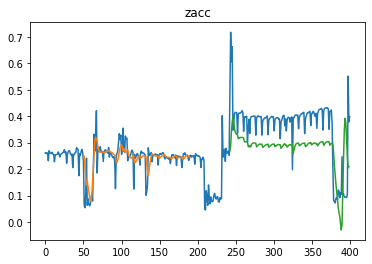

Number Of Training 23
zacc**************************************************
Train RMSE: 0.07609324157466194 /// Test RMSE 0.2555723345472449 /// Time Step 50 /// Number of layer 50


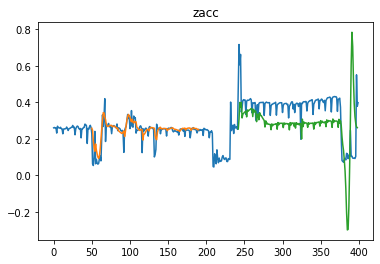

Number Of Training 24
zacc**************************************************
Train RMSE: 0.07606438558181182 /// Test RMSE 0.24006567713357765 /// Time Step 50 /// Number of layer 100


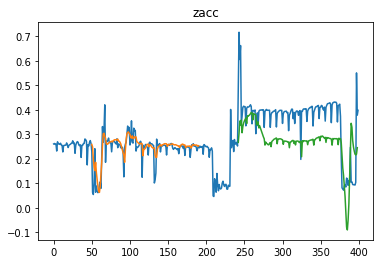

Number Of Training 25
zacc**************************************************
Train RMSE: 0.07835739395137267 /// Test RMSE 0.23944029591944366 /// Time Step 90 /// Number of layer 20


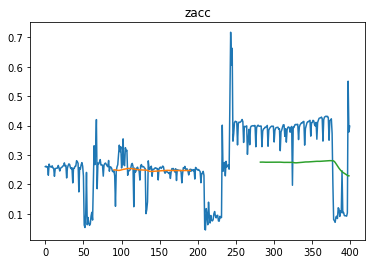

Number Of Training 26
zacc**************************************************
Train RMSE: 0.08120834044107914 /// Test RMSE 0.24411315612145926 /// Time Step 90 /// Number of layer 30


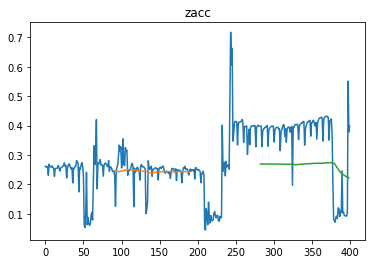

Number Of Training 27
zacc**************************************************
Train RMSE: 0.06840180205305318 /// Test RMSE 0.22504868484141438 /// Time Step 90 /// Number of layer 50


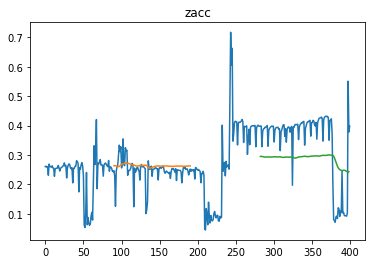

Number Of Training 28
zacc**************************************************
Train RMSE: 0.07360467635857025 /// Test RMSE 0.25376398229295216 /// Time Step 90 /// Number of layer 100


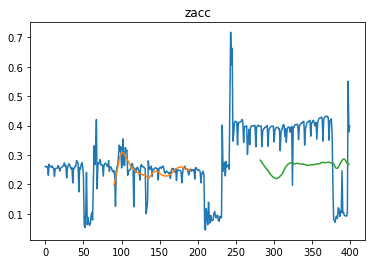

In [ ]:
lstm_tuning(df,df.columns[4])

# zacc column Best model

zacc**************************************************
Train RMSE: 0.08498606821632235 /// Test RMSE 0.1772899893169744 /// Time Step 3 /// Number of layer 30


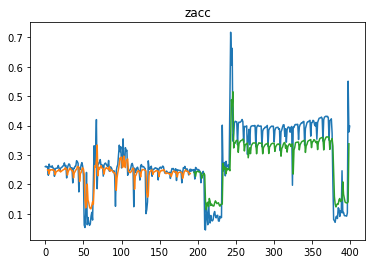

(0.08498606821632235,
 0.1772899893169744,
 <tensorflow.python.keras.engine.sequential.Sequential at 0x7f5b3001d0d0>)

In [37]:
lstm(df,"zacc","2020-01-25 00:00:00",time_step=3,layer_num=30)

# crest column model tuning

Number Of Training 1
crest**************************************************
Train RMSE: 4.209452110020902 /// Test RMSE 4.608922284454682 /// Time Step 3 /// Number of layer 20


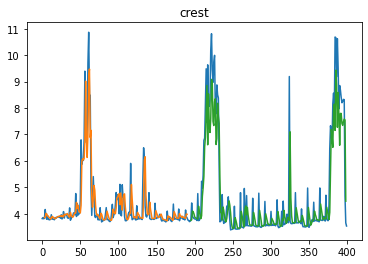

Number Of Training 2
crest**************************************************
Train RMSE: 4.207962280106423 /// Test RMSE 4.632312638623733 /// Time Step 3 /// Number of layer 30


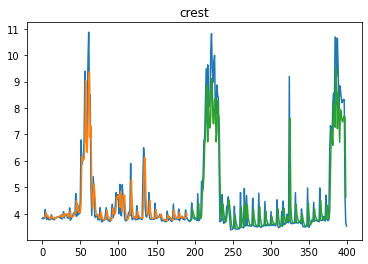

Number Of Training 3
crest**************************************************
Train RMSE: 4.183653216182285 /// Test RMSE 4.564731426127695 /// Time Step 3 /// Number of layer 50


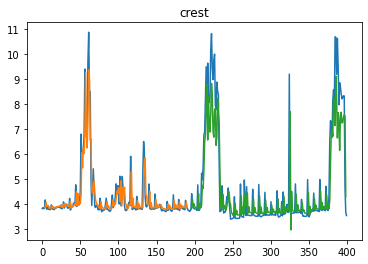

Number Of Training 4
crest**************************************************
Train RMSE: 4.281421564187122 /// Test RMSE 4.758689496371447 /// Time Step 3 /// Number of layer 100


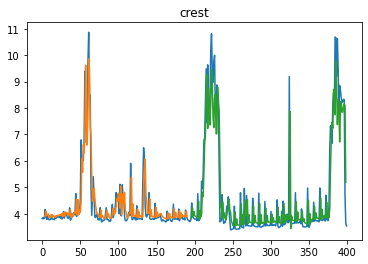

Number Of Training 5
crest**************************************************
Train RMSE: 4.2358646563404445 /// Test RMSE 4.274976557543021 /// Time Step 10 /// Number of layer 20


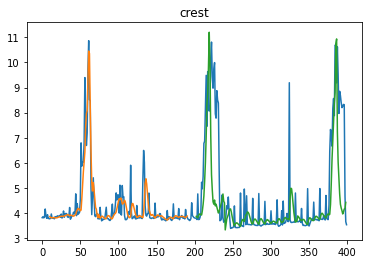

Number Of Training 6
crest**************************************************
Train RMSE: 4.288028028435461 /// Test RMSE 4.358634424149058 /// Time Step 10 /// Number of layer 30


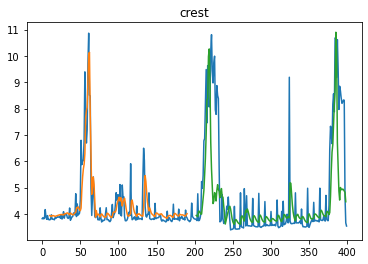

Number Of Training 7
crest**************************************************
Train RMSE: 4.328613066299098 /// Test RMSE 4.343562480080672 /// Time Step 10 /// Number of layer 50


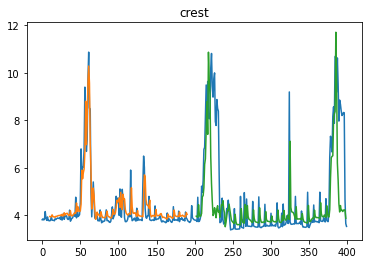

Number Of Training 8
crest**************************************************
Train RMSE: 4.279292899915731 /// Test RMSE 4.498888396632943 /// Time Step 10 /// Number of layer 100


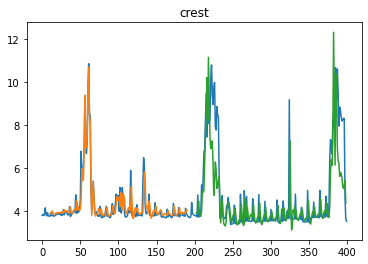

Number Of Training 9
crest**************************************************
Train RMSE: 4.289975436131524 /// Test RMSE 4.579219174238793 /// Time Step 15 /// Number of layer 20


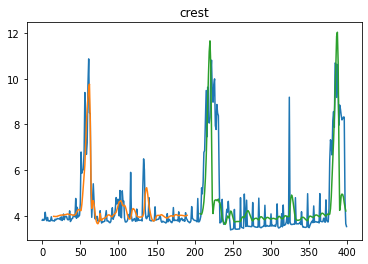

Number Of Training 10
crest**************************************************
Train RMSE: 4.169973126019654 /// Test RMSE 4.375797493118402 /// Time Step 15 /// Number of layer 30


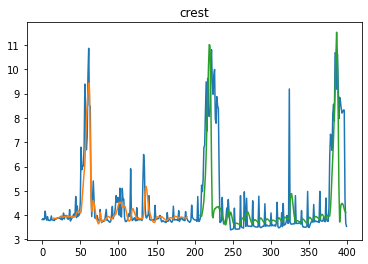

Number Of Training 11
crest**************************************************
Train RMSE: 4.251507563044368 /// Test RMSE 4.426205712170588 /// Time Step 15 /// Number of layer 50


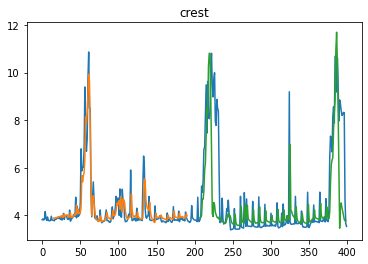

Number Of Training 12
crest**************************************************
Train RMSE: 4.273711868399391 /// Test RMSE 4.463964049261847 /// Time Step 15 /// Number of layer 100


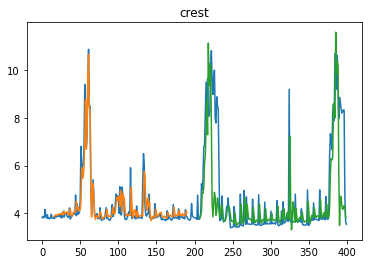

Number Of Training 13
crest**************************************************
Train RMSE: 4.188197984624953 /// Test RMSE 4.434153948131485 /// Time Step 20 /// Number of layer 20


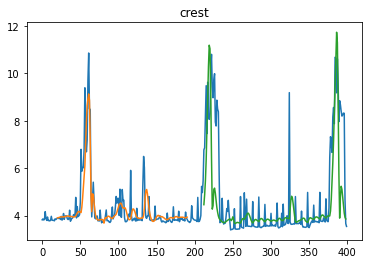

Number Of Training 14
crest**************************************************
Train RMSE: 4.277584733450483 /// Test RMSE 4.445103516932817 /// Time Step 20 /// Number of layer 30


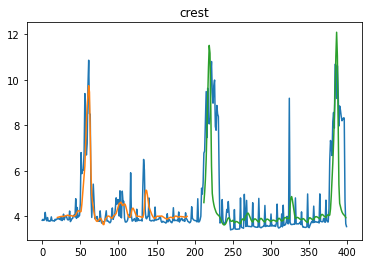

Number Of Training 15
crest**************************************************
Train RMSE: 4.332449055944584 /// Test RMSE 4.598909050465166 /// Time Step 20 /// Number of layer 50


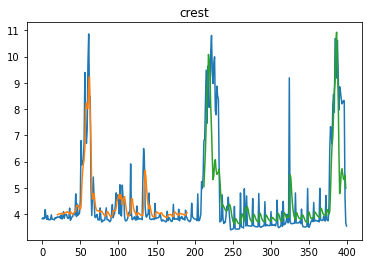

Number Of Training 16
crest**************************************************
Train RMSE: 4.30646141771542 /// Test RMSE 4.608728667264815 /// Time Step 20 /// Number of layer 100


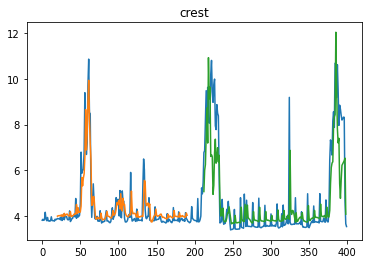

Number Of Training 17
crest**************************************************
Train RMSE: 4.2764632642999745 /// Test RMSE 4.257771970995402 /// Time Step 30 /// Number of layer 20


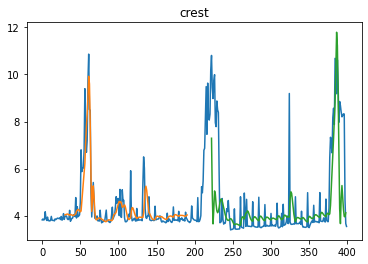

Number Of Training 18
crest**************************************************
Train RMSE: 4.225201169944705 /// Test RMSE 4.198065627627452 /// Time Step 30 /// Number of layer 30


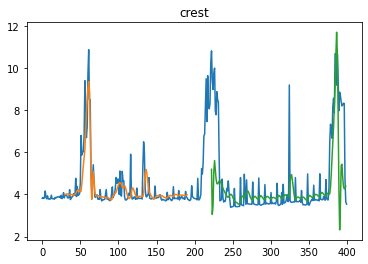

Number Of Training 19
crest**************************************************
Train RMSE: 4.234508768344701 /// Test RMSE 4.2438460119525 /// Time Step 30 /// Number of layer 50


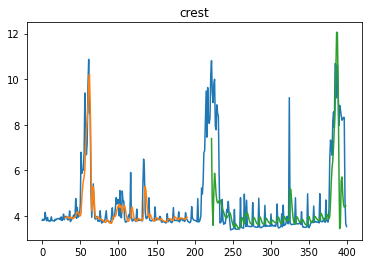

Number Of Training 20
crest**************************************************
Train RMSE: 4.26027713786187 /// Test RMSE 4.343055685045658 /// Time Step 30 /// Number of layer 100


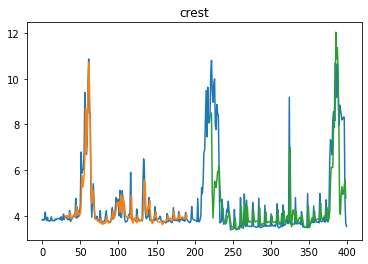

Number Of Training 21
crest**************************************************
Train RMSE: 4.414631177450477 /// Test RMSE 4.318813110424031 /// Time Step 50 /// Number of layer 20


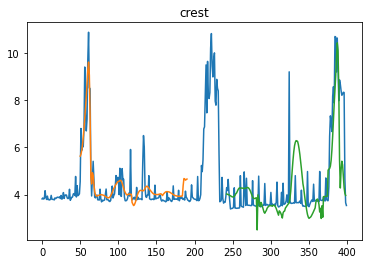

Number Of Training 22
crest**************************************************
Train RMSE: 4.397161398451868 /// Test RMSE 4.828587187717315 /// Time Step 50 /// Number of layer 30


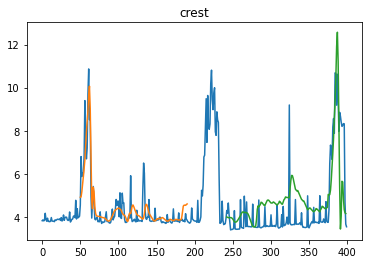

Number Of Training 23
crest**************************************************
Train RMSE: 4.3090344612718186 /// Test RMSE 4.536323394513514 /// Time Step 50 /// Number of layer 50


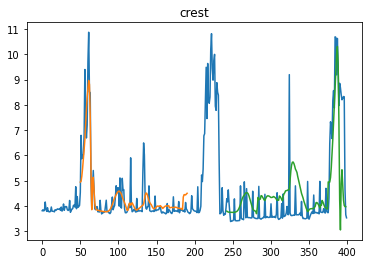

Number Of Training 24
crest**************************************************
Train RMSE: 4.3823873801291136 /// Test RMSE 4.40164096849091 /// Time Step 50 /// Number of layer 100


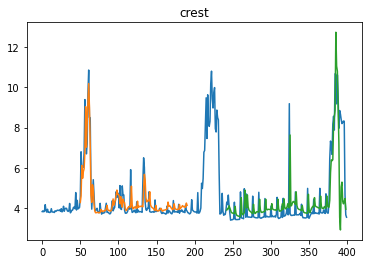

Number Of Training 25
crest**************************************************
Train RMSE: 3.987766091444958 /// Test RMSE 3.834626189556532 /// Time Step 90 /// Number of layer 20


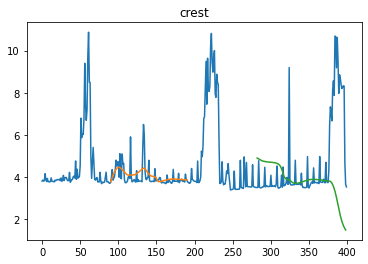

Number Of Training 26
crest**************************************************
Train RMSE: 3.9300534199442274 /// Test RMSE 3.5531157472092993 /// Time Step 90 /// Number of layer 30


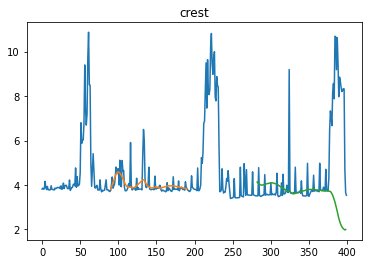

Number Of Training 27
crest**************************************************
Train RMSE: 3.9046135121141163 /// Test RMSE 3.739885455760817 /// Time Step 90 /// Number of layer 50


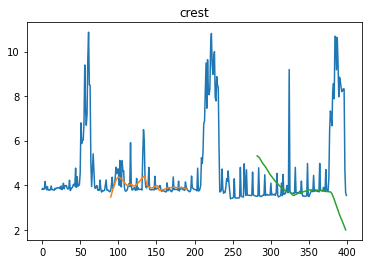

Number Of Training 28
crest**************************************************
Train RMSE: 4.045035674889446 /// Test RMSE 3.806286881841543 /// Time Step 90 /// Number of layer 100


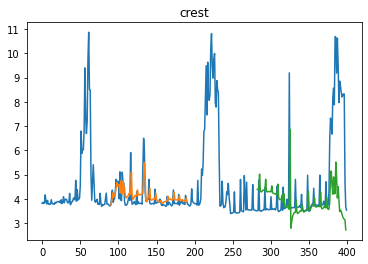

In [ ]:
lstm_tuning(df,df.columns[5])

# crest column best model

crest**************************************************
Train RMSE: 4.175338451106033 /// Test RMSE 4.581588965553361 /// Time Step 3 /// Number of layer 20


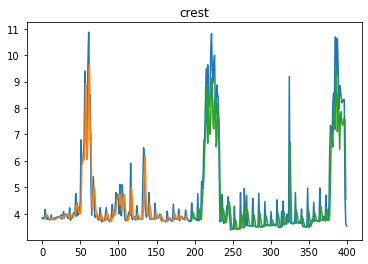

(4.175338451106033,
 4.581588965553361,
 <tensorflow.python.keras.engine.sequential.Sequential at 0x7f5b3d46fa50>)

In [38]:
lstm(df,"crest","2020-01-25 00:00:00",time_step=3,layer_num=20)

#zfreq column model tuning

Number Of Training 1
zfreq**************************************************
Train RMSE: 0.2737453812702585 /// Test RMSE 0.44027392252535974 /// Time Step 3 /// Number of layer 20


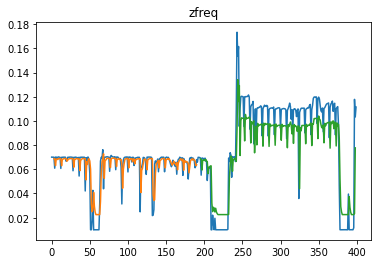

Number Of Training 2
zfreq**************************************************
Train RMSE: 0.2737946104899369 /// Test RMSE 0.44287663041624376 /// Time Step 3 /// Number of layer 30


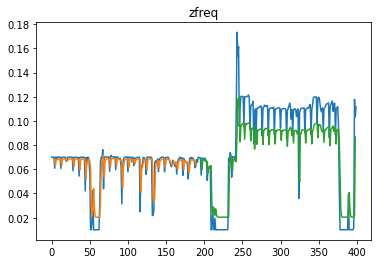

Number Of Training 3
zfreq**************************************************
Train RMSE: 0.27355312215553906 /// Test RMSE 0.44577864840372167 /// Time Step 3 /// Number of layer 50


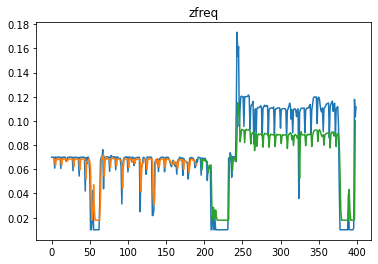

Number Of Training 4
zfreq**************************************************
Train RMSE: 0.2727924150378784 /// Test RMSE 0.44878407081199895 /// Time Step 3 /// Number of layer 100


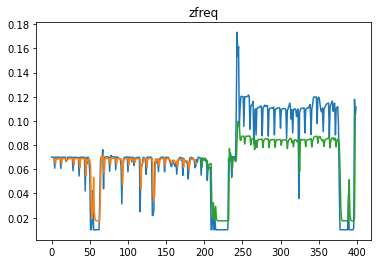

Number Of Training 5
zfreq**************************************************
Train RMSE: 0.2735152691717101 /// Test RMSE 0.4443983129850456 /// Time Step 10 /// Number of layer 20


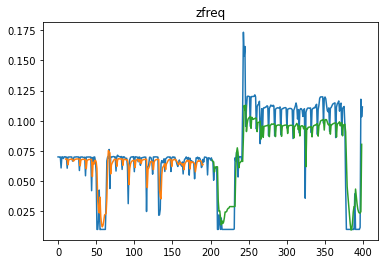

Number Of Training 6
zfreq**************************************************
Train RMSE: 0.27244609205767856 /// Test RMSE 0.4524073021659735 /// Time Step 10 /// Number of layer 30


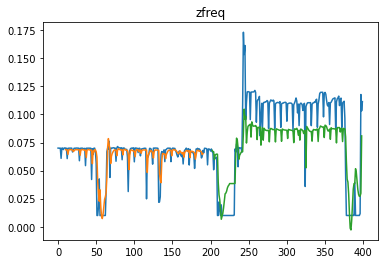

Number Of Training 7
zfreq**************************************************
Train RMSE: 0.2744491523616368 /// Test RMSE 0.4518600312173666 /// Time Step 10 /// Number of layer 50


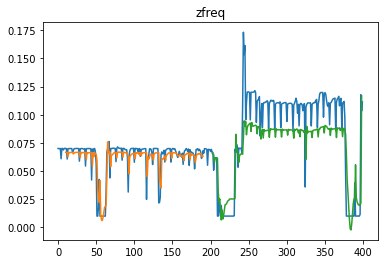

Number Of Training 8
zfreq**************************************************
Train RMSE: 0.2735447653565426 /// Test RMSE 0.4554097877267433 /// Time Step 10 /// Number of layer 100


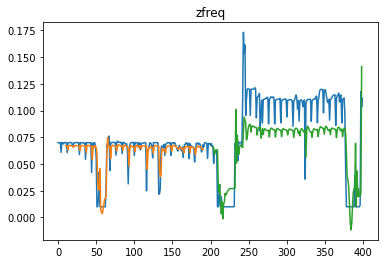

Number Of Training 9
zfreq**************************************************
Train RMSE: 0.2712640932427714 /// Test RMSE 0.45546277104006017 /// Time Step 15 /// Number of layer 20


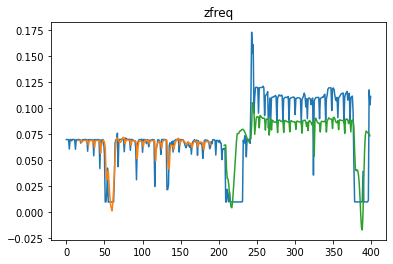

Number Of Training 10
zfreq**************************************************
Train RMSE: 0.2748266555377249 /// Test RMSE 0.4637012271490772 /// Time Step 15 /// Number of layer 30


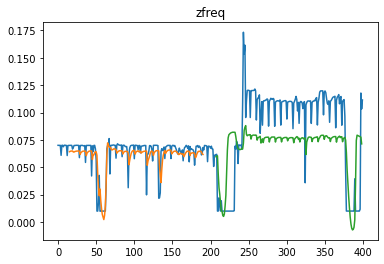

Number Of Training 11
zfreq**************************************************
Train RMSE: 0.27459744334495295 /// Test RMSE 0.4585079905844293 /// Time Step 15 /// Number of layer 50


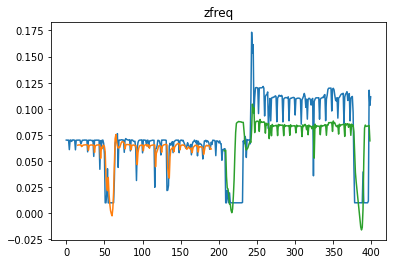

Number Of Training 12
zfreq**************************************************
Train RMSE: 0.2725436493903702 /// Test RMSE 0.45778172520741955 /// Time Step 15 /// Number of layer 100


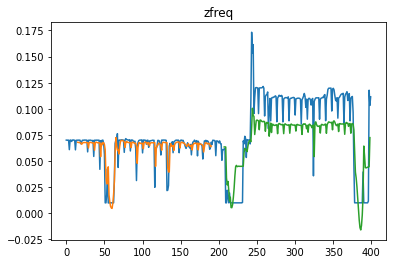

Number Of Training 13
zfreq**************************************************
Train RMSE: 0.27194938471556307 /// Test RMSE 0.4653907168523381 /// Time Step 20 /// Number of layer 20


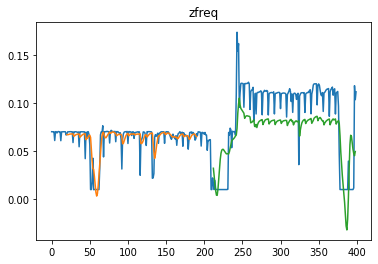

Number Of Training 14
zfreq**************************************************
Train RMSE: 0.2726760436522958 /// Test RMSE 0.4625262619807448 /// Time Step 20 /// Number of layer 30


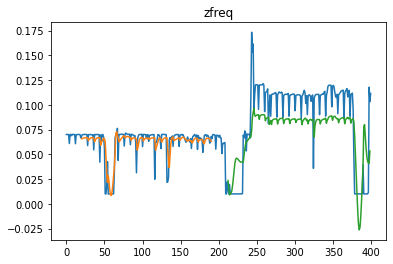

Number Of Training 15
zfreq**************************************************
Train RMSE: 0.2718312958920516 /// Test RMSE 0.4626070306797688 /// Time Step 20 /// Number of layer 50


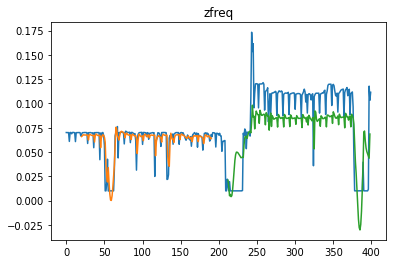

Number Of Training 16
zfreq**************************************************
Train RMSE: 0.2717532695678863 /// Test RMSE 0.46354969816518926 /// Time Step 20 /// Number of layer 100


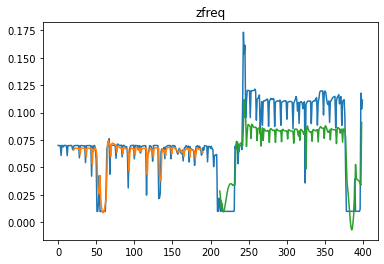

Number Of Training 17
zfreq**************************************************
Train RMSE: 0.27099935122194857 /// Test RMSE 0.48572357809800154 /// Time Step 30 /// Number of layer 20


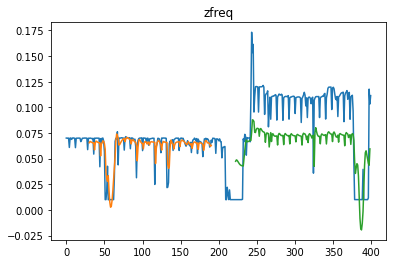

Number Of Training 18
zfreq**************************************************
Train RMSE: 0.27061204406694955 /// Test RMSE 0.4815365814704547 /// Time Step 30 /// Number of layer 30


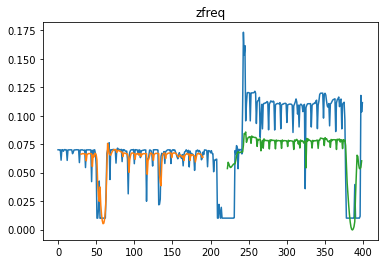

Number Of Training 19
zfreq**************************************************
Train RMSE: 0.26868088649455096 /// Test RMSE 0.4789401034031551 /// Time Step 30 /// Number of layer 50


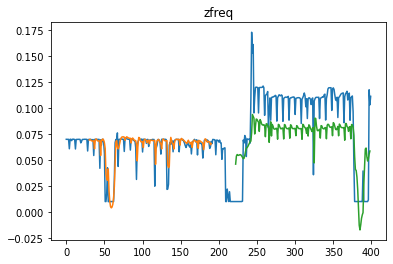

Number Of Training 20
zfreq**************************************************
Train RMSE: 0.27131491330990865 /// Test RMSE 0.4806485736902861 /// Time Step 30 /// Number of layer 100


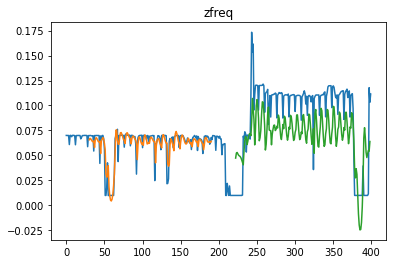

Number Of Training 21
zfreq**************************************************
Train RMSE: 0.26952999931147903 /// Test RMSE 0.5048858680319307 /// Time Step 50 /// Number of layer 20


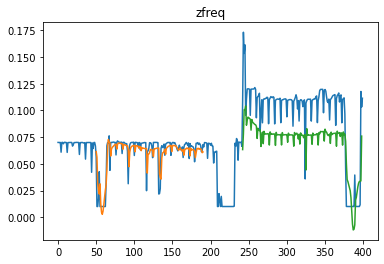

Number Of Training 22
zfreq**************************************************
Train RMSE: 0.2695051076728737 /// Test RMSE 0.5145235555797506 /// Time Step 50 /// Number of layer 30


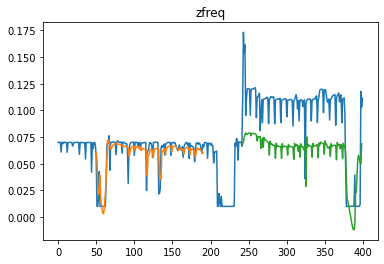

Number Of Training 23
zfreq**************************************************
Train RMSE: 0.2682935308393564 /// Test RMSE 0.5114506858206347 /// Time Step 50 /// Number of layer 50


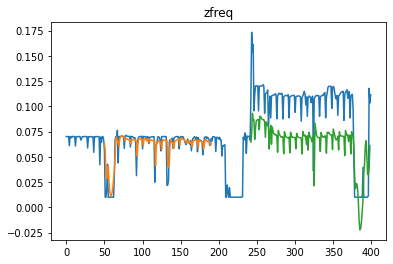

Number Of Training 24
zfreq**************************************************
Train RMSE: 0.2684540380194745 /// Test RMSE 0.5063475905446011 /// Time Step 50 /// Number of layer 100


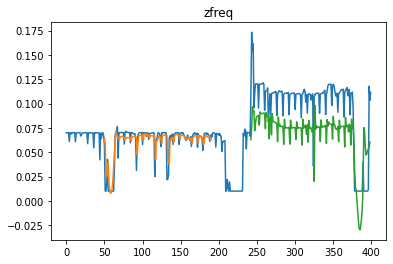

Number Of Training 25
zfreq**************************************************
Train RMSE: 0.2788132304957734 /// Test RMSE 0.4903748626266162 /// Time Step 90 /// Number of layer 20


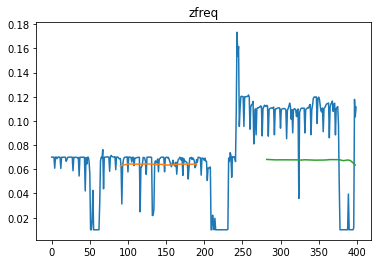

Number Of Training 26
zfreq**************************************************
Train RMSE: 0.2793980511409008 /// Test RMSE 0.490607468414073 /// Time Step 90 /// Number of layer 30


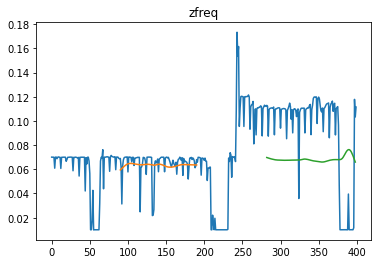

Number Of Training 27
zfreq**************************************************
Train RMSE: 0.2788765643153533 /// Test RMSE 0.4928797642191598 /// Time Step 90 /// Number of layer 50


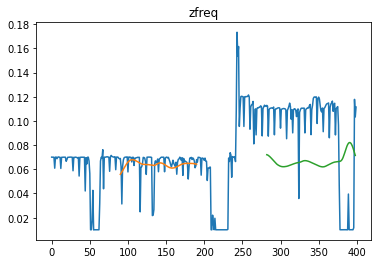

Number Of Training 28
zfreq**************************************************
Train RMSE: 0.2787175742344221 /// Test RMSE 0.4935076147850321 /// Time Step 90 /// Number of layer 100


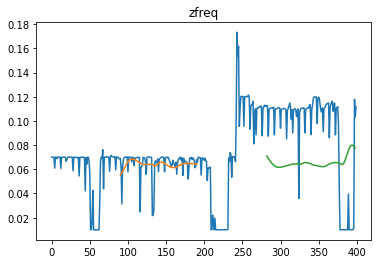

In [ ]:
lstm_tuning(df,df.columns[6])

# zfreq column best model

zfreq**************************************************
Train RMSE: 0.2746609969027364 /// Test RMSE 0.4481875269656834 /// Time Step 3 /// Number of layer 30


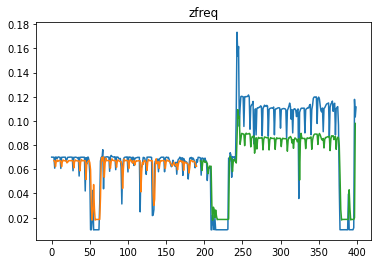

(0.2746609969027364,
 0.4481875269656834,
 <tensorflow.python.keras.engine.sequential.Sequential at 0x7f5b2cbed450>)

In [39]:
lstm(df,"zfreq","2020-01-25 00:00:00",time_step=3,layer_num=30)